In [1]:
%matplotlib inline
#import the read_block function from the tdt package
#also import other python packages we care about
import numpy as np
import pandas as pd 
from sklearn.metrics import auc
import matplotlib.pyplot as plt  # standard Python plotting library
import scipy.stats as stats

import tdt

import os
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

import matplotlib 
matplotlib.rcParams['font.size'] = 16 #set font size for all plots

#set default plot properties
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.rcParams['axes.labelsize'] = 12     #Set default axes label size 
plt.rcParams['axes.titlesize']=15
plt.rcParams['axes.titleweight']='heavy'
plt.rcParams['ytick.labelsize']= 10
plt.rcParams['xtick.labelsize']= 10
plt.rcParams['legend.fontsize']=12
plt.rcParams['legend.markerscale']=2

In [7]:
#load file, set name for each channel, set time and sampling rate read from tdt block

BLOCK_PATH = '/path to tdt file/'

ISOS = '_405A'
GCaMP = '_465A'

data = tdt.read_block(BLOCK_PATH)
time = np.linspace(1,len(data.streams[GCaMP].data), len(data.streams[GCaMP].data))/data.streams[GCaMP].fs
sampling_rate = data.streams[GCaMP].fs

GCaMP_raw = data.streams[GCaMP].data
ISOS_raw = data.streams[ISOS].data

event_times = [t]

read from t=0s to t=247.64s


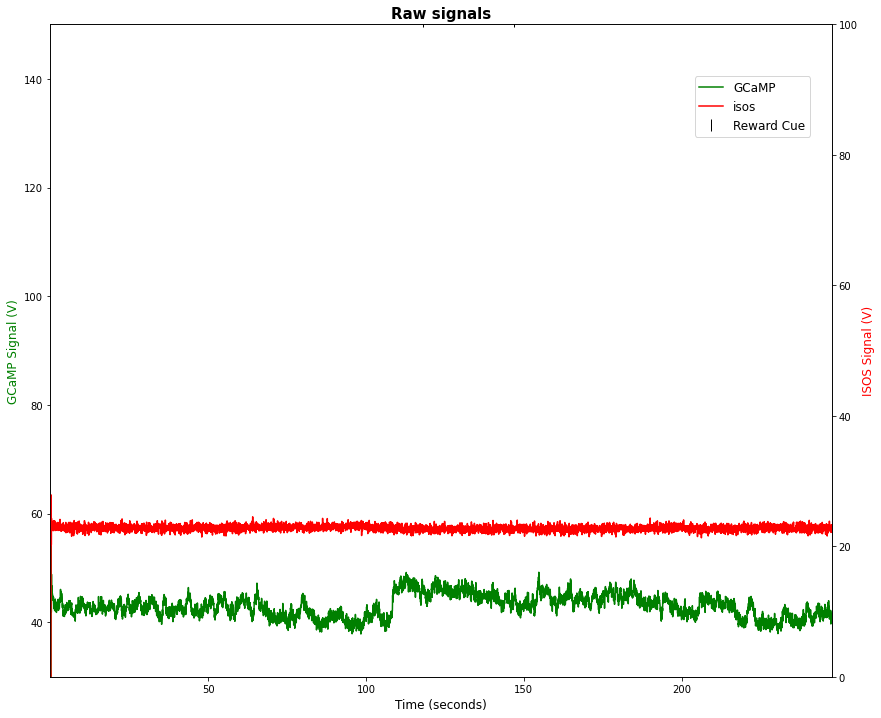

In [8]:
# Raw signals

fig,ax1=plt.subplots()  # create a plot to allow for dual y-axes plotting
plot1=ax1.plot(time, GCaMP_raw, 'g', label='GCaMP') 
ax2=plt.twinx()# create a right y-axis, sharing x-axis on the same plot
plot2=ax2.plot(time, ISOS_raw, 'r', label='isos') 

# Plot rewards times as ticks.
event_ticks = ax1.plot(event_times, np.full(np.size(event_times), 150), label='Event', color='w', marker="|", mec='k')


ax1.set_ylim(30, 150)
ax2.set_ylim(0, 100)
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('GCaMP Signal (V)', color='g')
ax2.set_ylabel('ISOS Signal (V)', color='r')
ax1.set_title('Raw signals')

lines = plot1 + plot2 + event_ticks #line handle for legend
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.98, 0.93)) #add legend

In [11]:
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.adjust the filter frequecy accordingly
b,a = butter(2, 10, btype='low', fs=sampling_rate)
gcamp_denoised = filtfilt(b,a, GCaMP_raw)
isos_denoised = filtfilt(b,a, ISOS_raw)

# The double exponential curve we are going to fit.
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    '''Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset. 
    amp_fast: Amplitude of the fast component.  
    amp_slow: Amplitude of the slow component.  
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow. 
    '''
    tau_fast = tau_slow*tau_multiplier
    return const+amp_slow*np.exp(-t/tau_slow)+amp_fast*np.exp(-t/tau_fast)

# Fit curve to GCaMP signal.
max_sig = np.max(gcamp_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
gcamp_parms, parm_cov = curve_fit(double_exponential, time, gcamp_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
gcamp_expfit = double_exponential(time, *gcamp_parms)

# Fit curve to ISOS signal.
max_sig = np.max(isos_denoised)
inital_params = [max_sig/2, max_sig/4, max_sig/4, 3600, 0.1]
bounds = ([0      , 0      , 0      , 600  , 0],
          [max_sig, max_sig, max_sig, 36000, 1])
isos_parms, parm_cov = curve_fit(double_exponential, time, isos_denoised, 
                                  p0=inital_params, bounds=bounds, maxfev=1000)
isos_expfit = double_exponential(time, *isos_parms)

#detrended

gcamp_detrended = gcamp_denoised - gcamp_expfit
isos_detrended = isos_denoised - isos_expfit

#motion correction
slope, intercept, r_value, p_value, std_err = linregress(x=gcamp_detrended, y=isos_detrended)

gcamp_est_motion = intercept + slope * isos_detrended
gcamp_corrected = gcamp_detrended - gcamp_est_motion


# downsample
desired_sampling_rate = 20  # Desired sampling rate in Hz
Fs_original = data.streams[GCaMP].fs
interval_seconds = 0.05

# Calculate N for desired sampling rate
N = int(Fs_original / desired_sampling_rate)

length = len(gcamp_corrected)

# Adjust the length of the data to ensure exact multiple of samples_interval
new_length = length - (length % N)

# Downsample and extract data at the specified interval for GCaMP
gcamp_downsampled = [np.mean(gcamp_corrected[i:i+N]) for i in range(0, new_length, N)]
time_downsampled = [np.mean(time[i:i+N]) for i in range(0, new_length, N)]

df1 = pd.DataFrame({'Time': time_downsampled, 'GCaMP': gcamp_downsampled})

filename = 'gcamp_downsampled.xlsx'
file_path = os.path.join(BLOCK_PATH, filename)

#saving data frame to the same directory

df1.to_excel(file_path, index=False)


#calculate zscore with self-defined baseline

baseline_end = 108 # End of the baseline period in seconds

# Calculate the start of the baseline period
baseline_start = baseline_end - 10
time_step = np.mean(np.diff(time_downsampled))

# Convert time points to indices
baseline_start_idx = int(baseline_start / time_step)
baseline_end_idx = int(baseline_end / time_step)

# Calculate the mean and standard deviation of the baseline period
baseline_mean = np.mean(gcamp_downsampled[baseline_start_idx:baseline_end_idx])
baseline_std = np.std(gcamp_downsampled[baseline_start_idx:baseline_end_idx])

gcamp_zscore = gcamp_downsampled[baseline_start_idx:]
time_zscore = time_downsampled[baseline_start_idx:]

# Adjust the timestamps to start from -10 seconds
time_cropped = [t  - baseline_end for t in time_zscore]


# Calculate the z-score until the end of the data
z_scores = []
for x in gcamp_zscore:
    z_scores.append((x - baseline_mean) / baseline_std)

# saving z_scores to a new data frame
df2 = pd.DataFrame({'Time_original': time_zscore, 'Time_aligned': time_cropped, 'Z-Score': z_scores})

filename = 'z_scores.xlsx'
file_path = os.path.join(BLOCK_PATH, filename)

# exporting the data frame to the same directory
df2.to_excel(file_path, index=False)

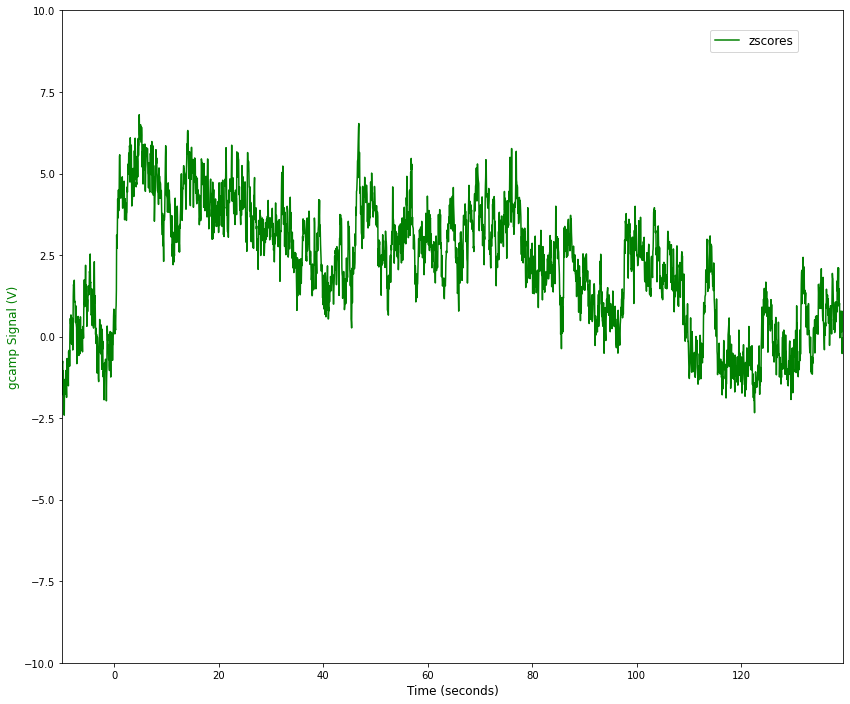

In [12]:
#plotting the z-score trace
fig,ax1=plt.subplots()  
plot1=ax1.plot(time_cropped,  z_scores, 'g', label='zscores')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('gcamp Signal (V)', color='g')
lines = plot1 
labels = [l.get_label() for l in lines]  
legend = ax1.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.95, 0.98))

ax1.set_ylim(-10, 10);